# AutoEncoder
- https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [10]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [11]:
x_train.min(), x_train.max() # 스케일링 되어 있음

(0.0, 1.0)

In [12]:
np.shape(tf.random.normal(shape=x_train.shape))

TensorShape([60000, 28, 28])

In [13]:
# 흑백이미지를 컬러로 변경(1채널을 3채널로 변경)
# 내 자료 갖고 할 때 컬러이미지를 사용하기 위해서 하는 작업
# 노이즈 추가하기 전에 작업
# from skimage import color
# x_train_color = [color.gray2rgb(x) for x in x_train]
# x_test_color = [color.gray2rgb(x) for x in x_test]

# # np.shape(color.gray2rgb(x_train[0])) # (28, 28, 3)
# plt.imshow(x_train_color[0])
# plt.show()

In [14]:
# np.shape(x_train_color)

In [15]:
# np.shape(x_train)

In [16]:
# noise는 오디오할 때 백색잡음(생활잡음) 이라고 해서 중요한 요소
# gray scale일 때는 shape = x_train.shape 해도 28*28이지만
# 컬러일 땐 28*28*3
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

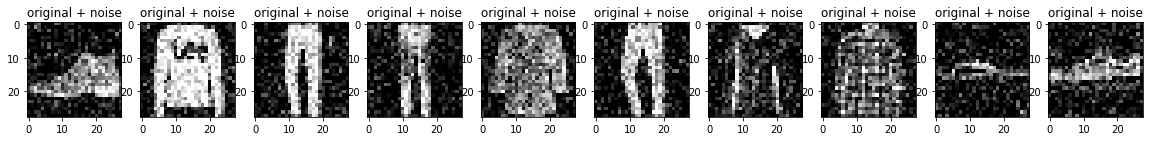

In [17]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

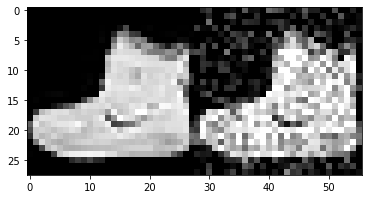

In [18]:
plt.imshow (np.concatenate( [x_train[0], x_train_noisy[0] ], axis = 1 ) ) 
plt.show()

In [19]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model

inputs = Input(shape=(28, 28,1))
x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
x = Flatten()(x)
latent = Dense(10)(x)
x = Dense(7 * 7 * 64)(latent)

x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(64, 3, 2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, 3, 2, activation='relu', padding='same')(x)
x = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x) # color일 때: Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

model = Model(inputs, x)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31370     
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0     

In [20]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
hist = model.fit(x_train_noisy, x_train, validation_data=(x_test_noisy, x_test), epochs=5, verbose=2)

Epoch 1/5
1875/1875 - 41s - loss: 0.0236 - accuracy: 0.5044 - val_loss: 0.0164 - val_accuracy: 0.5040
Epoch 2/5
1875/1875 - 10s - loss: 0.0154 - accuracy: 0.5069 - val_loss: 0.0148 - val_accuracy: 0.5051
Epoch 3/5
1875/1875 - 10s - loss: 0.0143 - accuracy: 0.5073 - val_loss: 0.0141 - val_accuracy: 0.5051
Epoch 4/5
1875/1875 - 10s - loss: 0.0137 - accuracy: 0.5075 - val_loss: 0.0138 - val_accuracy: 0.5052
Epoch 5/5
1875/1875 - 10s - loss: 0.0133 - accuracy: 0.5077 - val_loss: 0.0134 - val_accuracy: 0.5054


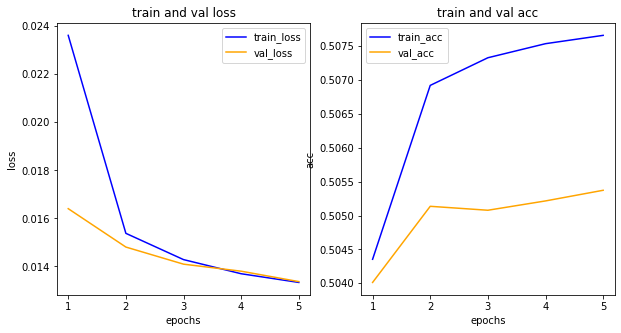

In [34]:
his_dict = hist.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

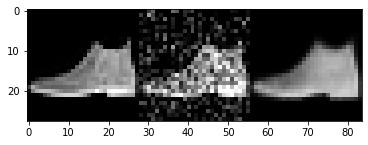

y값     x값     예측값


In [29]:
# test로 데이터 결과를 확인
res = model.predict(x_test_noisy[0:1])
plt.imshow(np.hstack([x_test[0], x_test_noisy[0], res[0].reshape(28,28)]))
plt.show()
print('y값     x값     예측값')

In [31]:
model.save('Auto_mnist_noisy_model.h5')

In [32]:
from google.colab import files
files.download('Auto_mnist_noisy_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>